In [1]:
using LinearAlgebra
using Plots
using Printf
using OffsetArrays
using Integrals
using StaticArrays

In [2]:
width = 1000
height = 400
fig_size = (width, height);

In [3]:
# @enum FlaxMethod LaxFriedrichs LaxWendroff Godunov #Roe # HLL HLLC
@enum BoundaryCondition Reflecting Extrapolate # Periodic
@enum SlopeLimiter Minmod VanLeer SuperBee MC  Godunov LaxWendroff None 
# todo can  merge solvers + limiters into limiters as different limiters correspond to different methods

In [4]:
sv = @SVector [1,2]

2-element SVector{2, Int64} with indices SOneTo(2):
 1
 2

In [5]:
println("test")

test


In [6]:
println("test2")
flush(stdout)

test2


In [7]:
cv = convert(MArray, sv)
cv

2-element MVector{2, Int64} with indices SOneTo(2):
 1
 2

In [8]:
cv[1] = -1

-1

In [9]:
convert(SVector, cv)

2-element SVector{2, Int64} with indices SOneTo(2):
 -1
  2

In [10]:
A = [1 0; 0 1]
λ, R =  eigen(A)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 1.0
 1.0
vectors:
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [11]:
R[:,2]

2-element Vector{Float64}:
 0.0
 1.0

In [12]:
0 < 1 ? 'a' : 'b'

'a': ASCII/Unicode U+0061 (category Ll: Letter, lowercase)

In [13]:
ϵ = 1e-20
ϵ / ϵ

1.0

In [46]:
struct OutputData
    q::Vector{SVector}
    gcL::Vector{SVector}
    gcR::Vector{SVector}
    ngc::Int32
    t::Float64
    x::Vector{Float64}
end


#= todo 

Use a grid structure to store the state
auxiliarry data that would otherwise be computed multiple times
ie matrixes, eigenvalues etc

=#
struct Grid
    q::Vector{SVector}
    A::AbstractMatrix
    R::AbstractMatrix
    Rinv::AbstractMatrix
    λ::Vector{Float64}
    dx::Float64
    x::Vector{Float64}
    ngc::Int32
end


function apply_boundary_condition!(q, bc, nbc; u_index=0)
    if bc == Reflecting
        for i in 1:nbc
            tmp = convert(MArray, q[i])
            tmp[u_index] = -tmp[u_index]
            q[1-i] = convert(SVector, tmp)

            tmp = convert(MArray, q[end  - nbc + 1 - i])
            tmp[u_index] = -tmp[u_index]
            q[end - nbc + i] = convert(SVector, tmp)

        end
        
    elseif bc == Extrapolate
        for i in 1:nbc
            q[1-i] = q[1]
            q[end-i+1] = q[end - i]
        end
    end
end



function get1dLimit(q, i, u, limiter) 
    I = u < 0 ? i + 1 :  i - 1
    ϵ = 1e-20
    dqi = q[i] - q[i-1]
    dqI = q[I] - q[I-1]

    α = (dqI[1] + ϵ)/(dqi[1] + ϵ)
    l = limit(α, limiter)

    if isnan(l)
        @printf "a=%d  dqi=%d  dqI=%d  i=%d \n" α dqi[1] dqI[1] i 
    end
    return  l
end
    

# todo write for systems
function rs(q, i, u::Number, dx, dt, limiter)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    ν = u * dt / dx

    if u >= 0
        am = get1dLimit(q, i, u, limiter)
        ap = get1dLimit(q, i+1, u, limiter)
        return q[i] -ν * dqm - 0.5 * ν *(1-ν) * ( ap * dqp - am * dqm)
    else
        am = get1dLimit(q, i, u, limiter)
        ap = get1dLimit(q, i+1, u, limiter)
        return q[i] -ν * dqp + 0.5 * ν *(1+ν) * ( ap * dqp - am * dqm)
    end
end

# since A is fixed can pass in the eigenvalues and eigenvectors
# but can set up a grid on init or before the loop and copy as metadata to all cells
function rs(q, i, A::AbstractMatrix, dx, dt, limiter)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    λ, R = eigen(A)
    Rinv = inv(R)

    Ap = R * diagm(max.(λ, 0)) * Rinv
    Am = R * diagm(min.(λ, 0)) * Rinv

    Aabs = R * diagm(abs.(λ)) * Rinv


    # todo check if index is correct
    Fp = get_limited_flux(q, i+1, Aabs, λ, R, Rinv, limiter)
    Fm = get_limited_flux(q, i, Aabs, λ, R, Rinv, limiter)

    # @printf "i=%d Fp=%s  Fm=%s \n" i Fp Fm
    return q[i] - dt/dx * (Ap * dqm + Am * dqp) - dt/dx * (Fp - Fm)
end



function get_limited_flux(q, i, A, λ, R, Rinv, limiter) 
    f = zeros(length(λ))
    ϵ = 1e-20

    for j in 1:length(λ)
        l = λ[j]
        I = l < 0 ? i + 1 :  i - 1

        dqi = q[i] - q[i-1]
        dqI = q[I] - q[I-1]
        
        αIv = Rinv * dqI
        αI = αIv[j]
        
        αiv = Rinv * dqi
        αi = αiv[j]

        α = (αI + ϵ)/(αi + ϵ)
        α_tilde = limit(α, limiter) * αi

        r = R[:, j]

        f += abs(l) * (1 - dt/dx * abs(l)) * α_tilde * r  

        # todo fi limit crazy print something
        # @printf "a=%d  i=%d I=%s r=%s aI=%s  ai=%s Rinv=%s dq[i]=%s dg[I]=%s\n" α i I r αIv αiv  Rinv dqi dqI
    end
   
    return  0.5 * f
end



function limit(θ, limiter::SlopeLimiter) 
    if limiter == Minmod
        return minmod(1, θ)
    elseif limiter == SuperBee
        return max(0, min(1, 2*θ), min(2, θ))
    elseif limiter == MC
        return max(0, min((1+θ)/2, 2, 2*θ) )
    elseif limiter == Godunov
        return 0
    elseif limiter == LaxWendroff
        return 1
    elseif limiter == Beamwarming
        return θ
    elseif limiter == Fromm
        return (1+θ)/2
    end
    return 0
end

# todo use CFL rather than dt 
# proper way to call functions instead of defining them twice for 1d
# use fluxes rather than methods? and use a single methdo combining them
function LaxWendroffStep(q, i, A, dx, dt)
    return q[i] - 0.5 * dt/dx * A * (q[i+1] - q[i-1]) + 0.5 * (dt/dx)^2 * A^2 * (q[i-1] - 2*q[i] + q[i+1]) 
end


# write a method that takes the method enum and return the right function
# then use that in the loops rather than if/switch statements
function evolve(q, i, A, dt, dx, limiter)
    if limiter != None
        return rs(q, i, A, dx, dt, limiter)
    end 
end





function minmod(a, b)
    if a*b < 0
        return 0
    elseif abs(a) < abs(b)
        return a
    else
        return b
    end
end



function solve(A, a, b, dx , dt, tmax, g_initial; limiter=None, log_interval=0, boundary_condition=Extrapolate, u_index=0)
    
    # hardcoded boundary condition for now
    # 2 ghost cells front and back
    ngc = 2
|
    N = Int((b-a)/dx)+1
    @printf "N=%d\n" N

    ndim = length(g_initial(a))
    # initiliaze grid

        
    q0 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)
    q1 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)

    # improve later on

    for i in 1:N
        iv =  g_initial(a + (i-1)*dx)
        if isa(iv, Number)
            q0[i] = @SVector [iv]
        else
            q0[i] = iv
        end
    end


    x = collect(a:dx:b)
    τ = 0
    last_log = 0

    output = [OutputData(q0[1:N], q0[1-ngc:0], q0[N+1:N+ngc], ngc, τ, x)]

    # Linear constant coefficient problems for now
    while τ < tmax
        # boundary condition
        apply_boundary_condition!(q0, boundary_condition, ngc; u_index=u_index)

        for i in 1:N
            
            # reconstruction

            # evolution
            q1[i] = evolve(q0, i, A, dt, dx, limiter)
            # Averaging
            
            # todo check CFL condition
            flush(stdout)

        end

        # log
        if log_interval > 0 && τ - last_log > log_interval
            push!(output, OutputData(q1[1:N], q1[1-ngc:0], q1[N+1:N+ngc], ngc, τ, x))
            last_log = τ
        end

        # swap states
        q0, q1 = q1, q0
   
        τ += dt
    end

    push!(output, OutputData(q1[1:N], q0[1-ngc:0], q0[N+1:N+ngc], ngc, τ, x))
    return output
end




solve (generic function with 1 method)

In [32]:
g_ind(x, a, b) = if (x > a && x < b) 1 else 0 end

g_initial(x) = exp(-200*(x-0.3)^2)  + g_ind(x, 0.6, 0.8)

g_initial (generic function with 1 method)

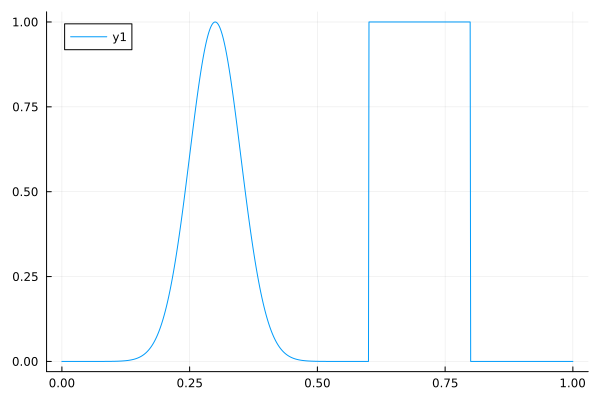

In [33]:
x = 0:0.001:1
plot(x, g_initial.(x))

In [34]:
u = 1
a = 0
b = 2
dx = 0.01
dt = 0.005

sol = solve(u, a, b, dx , dt, 0.2, g_initial; limiter=MC, log_interval=dt, boundary_condition=Reflecting, u_index=1)

N=201


35-element Vector{OutputData}:
 OutputData(SVector[[1.522997974471263e-8], [4.956405319172498e-8], [1.549753135702902e-7], [4.655715715783078e-7], [1.343812277631519e-6], [3.726653172078671e-6], [9.929504305851081e-6], [2.541934651619929e-5], [6.252150377482037e-5], [0.0001477483602320339]  …  [7.12942807022575e-226], [1.1156098461855145e-228], [1.6772515668267928e-231], [2.4227705982455765e-234], [3.36244046632459e-237], [4.483582170579293e-240], [5.744125024157209e-243], [7.070511862680189e-246], [8.361920750215328e-249], [9.501440650209124e-252]], SVector[[0.0], [0.0]], SVector[[0.0], [0.0]], 2, 0.0, [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])
 OutputData(SVector[[-2.499999999998551e-21], [2.1570667105656086e-9], [2.168523279898378e-8], [8.018182674250061e-8], [2.455978961770853e-7], [7.362383949915299e-7], [2.1101580800728263e-6], [5.800983970795052e-6], [1.5298036215632586e-5], [3.870710294160421e-5]  …

In [35]:
println("test")

test


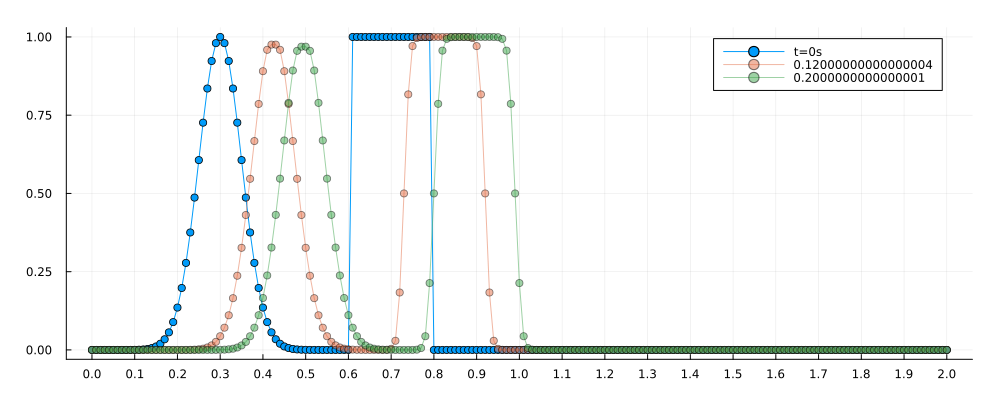

In [36]:
using Plots.PlotMeasures

n = Int(round(length(sol) / 2))
n = 20


plot(sol[1].x, first.(sol[1].q), marker=:circle, label="t=0s", size=fig_size, margin=5mm, xticks=0:0.1:2)
plot!(sol[n].x, first.(sol[n].q), marker=:circle, label="$(sol[n].t)", opacity=0.5)
plot!(sol[end].x, first.(sol[end].q), marker=:circle, label="$(sol[end].t)", opacity=0.5)

N=201


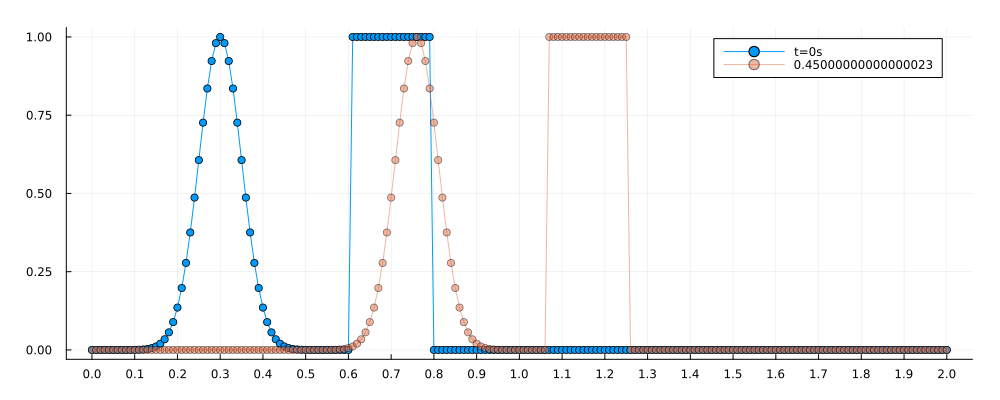

In [38]:
CFL = 1/2 

u_cfl = 1
a_cfl = 0
b_cfl = 2
dx_cfl = 0.01
dt_cfl = 0.01


n = 40
t = n * dt_cfl 

sol_cfl = solve(u_cfl, a_cfl, b_cfl, dx_cfl , dt_cfl, 1, g_initial; limiter=Godunov, log_interval=dt_cfl)

plot(sol_cfl[n].x, first.(sol_cfl[1].q), marker=:circle, label="t=0s", size=(1000, 400), margin=5mm, xticks=0:0.1:2)
plot!(sol_cfl[n].x, first.(sol_cfl[n].q), marker=:circle, label="$(sol_cfl[n].t)", opacity=0.5)

In [39]:
println("test")

test


In [74]:
p_0(x) = exp(-80*x^2)/2 + g_ind(x, -0.3, -0.1)/2
u_0(x) = 0 
q_0(x) = [p_0(x), u_0(x)]

q_0 (generic function with 1 method)

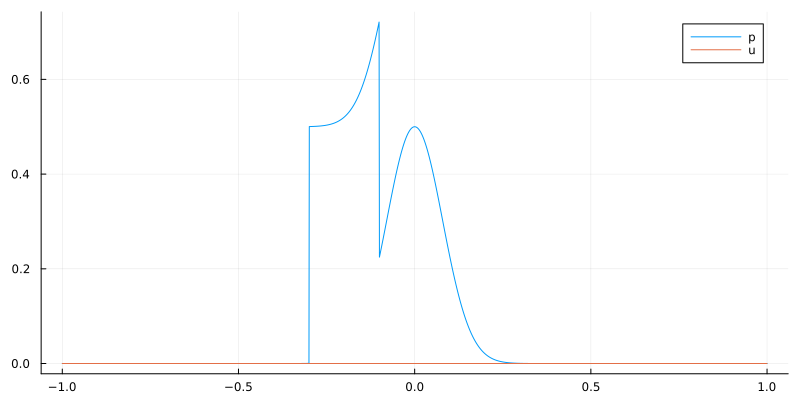

In [75]:
x = -1:0.001:1
plot(x, p_0.(x), label="p", size=(800, 400))
plot!(x, u_0.(x), label="u")

In [100]:
po = 1
Ko = 0.25

A = [0 Ko; 1/po 0]
dx = 0.005
dt = 0.005
tmax = 1

@printf "starting\n"
flush(stdout)
sol_acc = solve(A, -1, 1, dx , dt, tmax, q_0; limiter=MC, log_interval=0.1, boundary_condition=Extrapolate, u_index=2);

@printf "done"
flush(stdout)

starting
N=401
done

In [101]:
println("wtf")
flush(stdout)
flush(stderr)

wtf


In [102]:
@printf "a"
@printf "b"

ab

In [103]:
methods(rs)

# 2 methods for generic function "rs" from Main:
 [1] rs(q, i, u::Number, dx, dt, limiter)
     @ ~/Code/FVM/FVM/Chapter6/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:70
 [2] rs(q, i, A::AbstractMatrix, dx, dt, limiter)
     @ ~/Code/FVM/FVM/Chapter6/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:89

In [104]:
methods(solve)

# 1 method for generic function "solve" from Main:
 [1] solve(A, a, b, dx, dt, tmax, g_initial; limiter, log_interval, boundary_condition, u_index)
     @ ~/Code/FVM/FVM/Chapter6/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:196

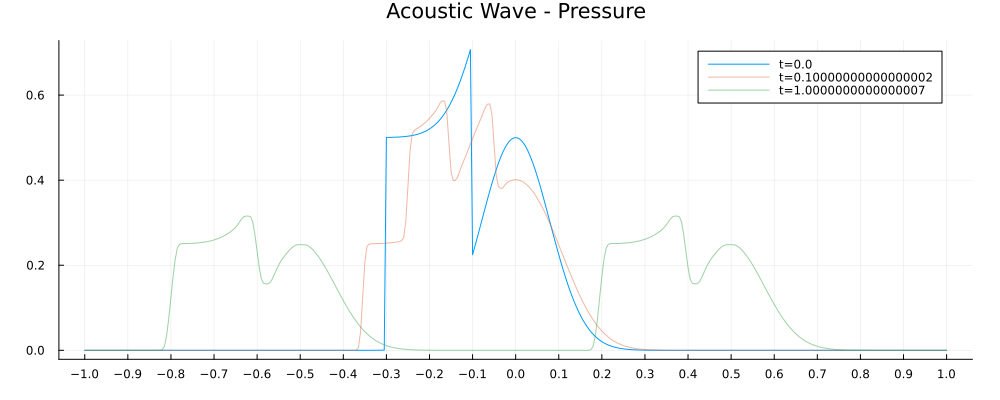

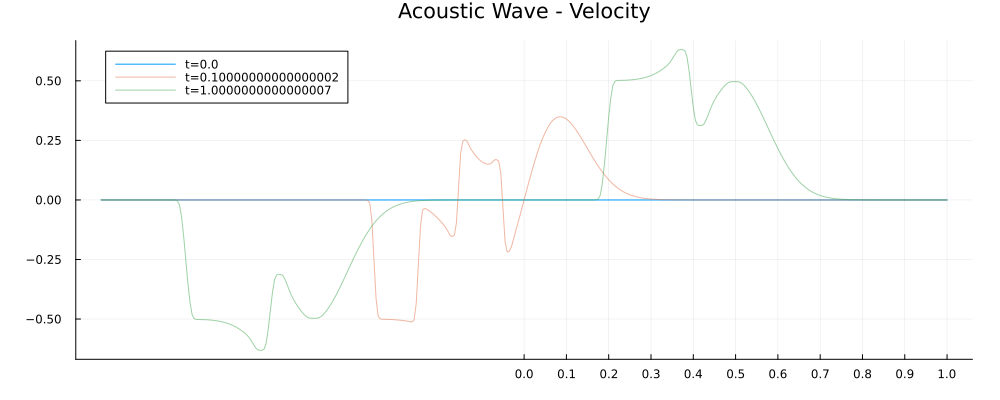

In [105]:
fig1 = plot(sol_acc[1].x, first.(sol_acc[1].q), label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=-1:0.1:1, title="Acoustic Wave - Pressure")
plot!(sol_acc[2].x, first.(sol_acc[2].q), label="t=$(sol_acc[2].t)", opacity=0.5)
plot!(sol_acc[end].x, first.(sol_acc[end].q), label="t=$(sol_acc[end].t)", opacity=0.5)

display(fig1)

fig2 = plot(sol_acc[1].x, getindex.(sol_acc[1].q, 2), label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=0:0.1:2,  title="Acoustic Wave - Velocity")
plot!(sol_acc[2].x, getindex.(sol_acc[2].q, 2), label="t=$(sol_acc[2].t)", opacity=0.5)
plot!(sol_acc[end].x, getindex.(sol_acc[end].q, 2), label="t=$(sol_acc[end].t)", opacity=0.5)
display(fig2)

In [106]:
fig = plot(sol_acc[1].x, getindex.(sol_acc[1].q, 2), marker=:circle, label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=0:0.1:2,  title="Acoustic Wave - Velocity")


for N in [20, 22, 24, 28]
    plot!(sol_acc[N].x, getindex.(sol_acc[N].q, 2), marker=:circle, label="t=$(sol_acc[N].t)", opacity=0.5)
end

display(fig)

BoundsError: BoundsError: attempt to access 11-element Vector{OutputData} at index [20]

In [29]:
fig = plot(sol_acc[1].x, getindex.(sol_acc[1].q, 1), marker=:circle, label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=0:0.1:2,  title="Acoustic Wave - Pressure")


for N in [20, 22, 24, 28]
    plot!(sol_acc[N].x, getindex.(sol_acc[N].q, 1), marker=:circle, label="t=$(sol_acc[N].t)", opacity=0.5)
end

display(fig)

BoundsError: BoundsError: attempt to access 2-element Vector{OutputData} at index [20]

In [30]:
size(q_0(0))

(2,)

In [31]:
ndims(q_0(0))

1